<a href="https://colab.research.google.com/github/ccasadei/corso-ia-2023/blob/master/02_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author: Cristiano Casadei**

Esempio di **transfer learning** applicato ad una rete convoluzionale per la classificazione di immagini.

Per la parte di **feature extraction** viene utilizzato un modello MobileNetV2 preaddestrato sul dataset **imagenet** ed il suo addestramento viene bloccato.

Per la parte di classificazione vengono utilizzati neuroni **fully connected**. Questa sarà l'unica parte addestrata della nuova rete neurale.

Come dataset viene utilizzato **Eurosat** che contiene immagini provenienti dal satellite **Sentinel2**. In questo caso sono utilizzate le immagini con i soli canali RGB.

In [3]:
# importo tutte le librerie che mi servono
import numpy as np
import matplotlib.pyplot as plt
from keras.applications import mobilenet_v3
import tensorflow_datasets as tfds
from keras.layers import Dense
from keras.models import Model
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

2023-03-01 13:33:46.075262: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


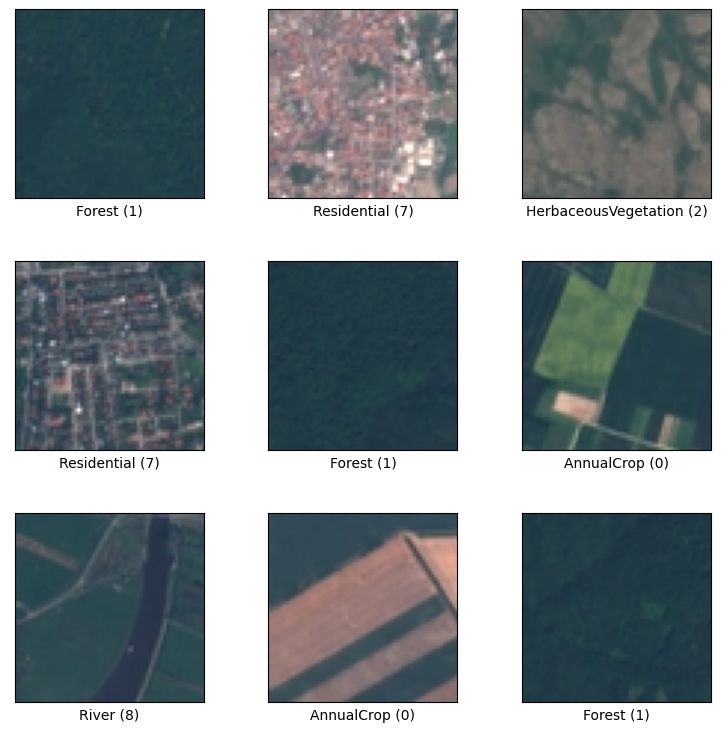

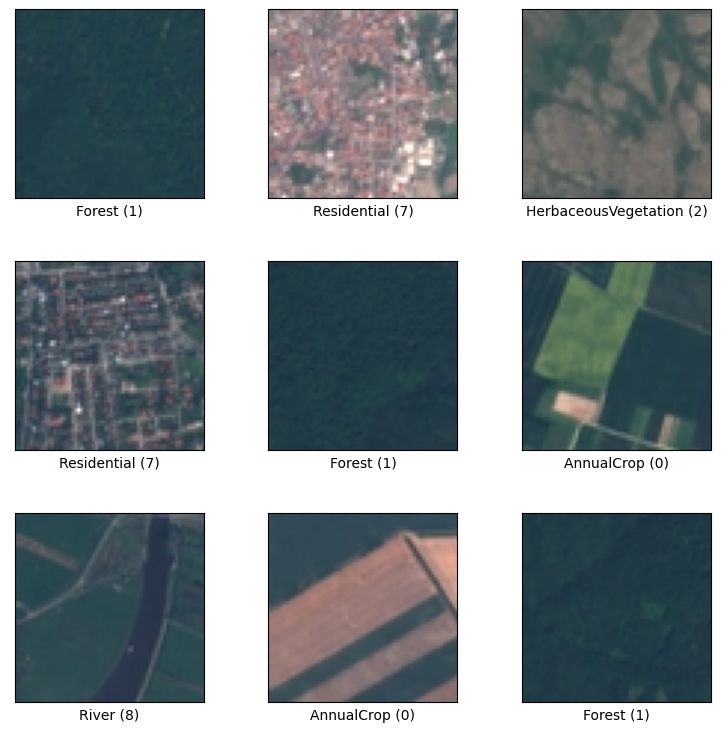

In [5]:
# carico il dataset e le informazioni
all, ds_info = tfds.load('eurosat/rgb', with_info=True)

# visualizzo alcuni esempi
tfds.show_examples(all["train"], ds_info)

In [6]:
# visualizzo cosa mi mette a disposizione il dataset
ds_info.features

FeaturesDict({
    'filename': Text(shape=(), dtype=string),
    'image': Image(shape=(64, 64, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})

In [7]:
# il dataset Eurosat contiene un unico insieme di immagini, chiamato "train"
# ottengo i sottoinsiemi di addestramento, validazione e test 
# utilizzando gli slice dell'insieme principale
#
#         E U R O S A T
# [..................|....|....]
#      T R A I N      VAL  TEST
#         80%          10%  10%
#
train = tfds.load('eurosat/rgb', split="train[:80%]", with_info=False)
validation = tfds.load('eurosat/rgb', split="train[80%:90%]", with_info=False)
test = tfds.load('eurosat/rgb', split="train[90%:]", with_info=False)

In [8]:
# ottengo l'insieme delle classi gestite in questo dataset
class_names = []
for i in range(ds_info.features["label"].num_classes):
    class_names.append(ds_info.features["label"].int2str(i))

# le visualizzo 
print("Ci sono %d classi" % len(class_names))
print()
for i, c in enumerate(class_names):
    print("Classe '%s' ---> ID %d" % (c, i))

Ci sono 10 classi

Classe 'AnnualCrop' ---> ID 0
Classe 'Forest' ---> ID 1
Classe 'HerbaceousVegetation' ---> ID 2
Classe 'Highway' ---> ID 3
Classe 'Industrial' ---> ID 4
Classe 'Pasture' ---> ID 5
Classe 'PermanentCrop' ---> ID 6
Classe 'Residential' ---> ID 7
Classe 'River' ---> ID 8
Classe 'SeaLake' ---> ID 9


Ci sono un totale di 27000 esempi

Numero di esempi per ogni classe


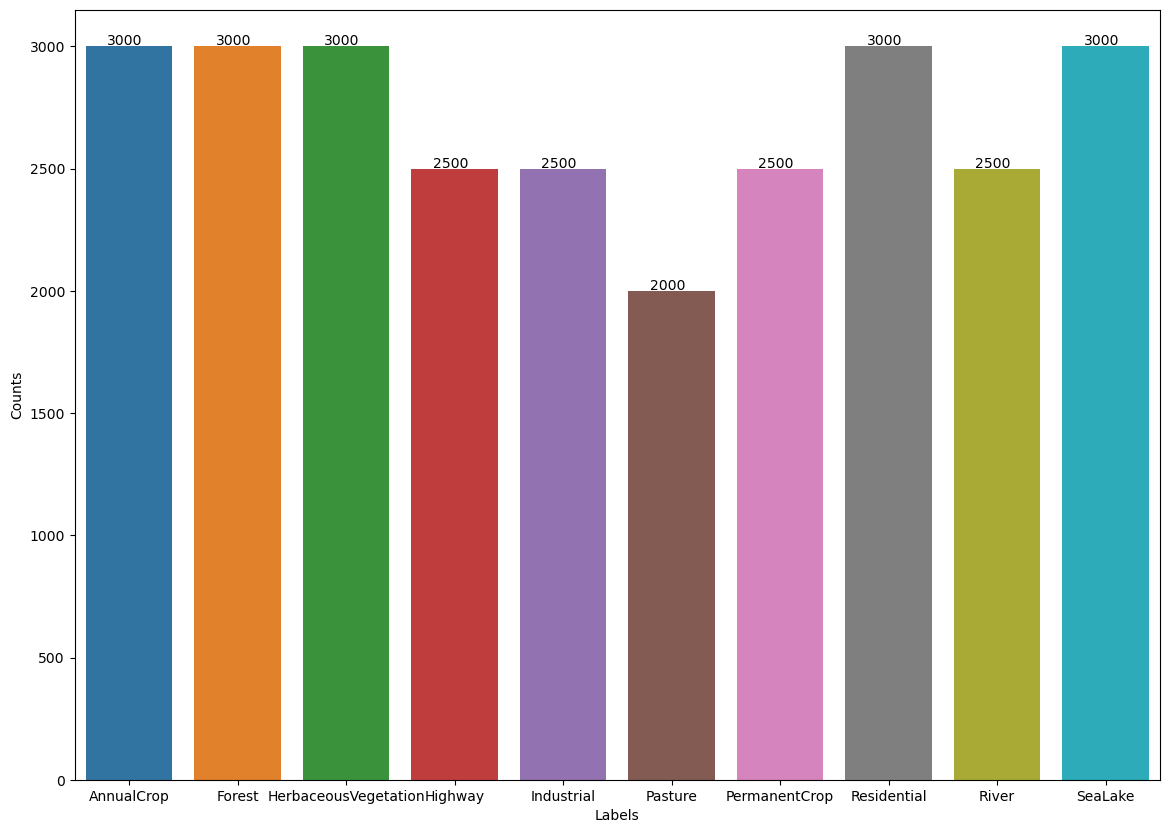

In [9]:
# visualizzo le frequenze di esempi per ogni classe
labels, counts = np.unique(np.fromiter(all["train"].map(lambda x: x["label"]), np.int32), return_counts=True)

print("Ci sono un totale di %d esempi" % sum(counts))
print()
print("Numero di esempi per ogni classe")

fig, ax = plt.subplots(1, 1, figsize=(14,10))

plt.ylabel('Counts')
plt.xlabel('Labels')
sns.barplot(x = [class_names[l] for l in labels], y = counts, ax=ax) 
for i, x_ in enumerate(labels):
  ax.text(x_-0.2, counts[i]+5, counts[i])


In [10]:
# definisco alcune costanti di lavoro
# dimensioni delle immagini in ingresso alla rete neurale (height x width)
INPUT_SHAPE = (224, 224)
# dimensione dei batch forniti alla rete
BATCH_SIZE = 128
# numero di epoche da elaborare
EPOCHS = 12

In [11]:
# definisco la funzione di preparazione delle immagini da fornire al modello convoluzionale
# questa funzione in sostanza ridimensiona l'immagine alla grandezza desiderata dal modello 
# ed esegue il preprocessing (normalizzazione) richiesto dal modello stesso
# infine ritorna l'immagine preprocessata e la label (la classe) trasformata in one-hot
def prepare_image(datapoint):
    image = tf.image.resize(datapoint["image"], INPUT_SHAPE)
    image = mobilenet_v3.preprocess_input(tf.cast(image, tf.float32))
    label = tf.one_hot(datapoint["label"], len(class_names))
    return image, label 

In [12]:
# preparo i gestori dei dati di addestramento, validazione e test
# per il train indico di utilizzare la funzione di preparazione di immagini
# poi di mischiare le immagini in modo che i batch non contengano sempre le stesse sequenze
# poi indico la dimensione dei batch da fornire
# infine chiedo di eseguire un precaricamento, per velocizzare gli accessi al disco
#
# per la validazione ed il test faccio la stessa cosa, ma evito di mischiare i dati 
# in quando non mi interessa 
ds_train = train.map(prepare_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .shuffle(2048) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.experimental.AUTOTUNE)

ds_validation = validation.map(prepare_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.experimental.AUTOTUNE)

ds_test = test.map(prepare_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
# definisco la parte di feature extraction che chiamo "backbone"
# indico le dimensioni delle immagini in input (a cui aggiungo la dimensione per i colori RGB)
# indico che desidero il modello preaddestrato sul dataset "imagenet" 
# inoltre non desidero la parte finale di classificazione in quando userò la mia 
# infine desidero che l'ultimo layer sia un average pooling, in modo da eliminare le dimensioni delle feature map convoluzionali
backbone = mobilenet_v3.MobileNetV3Small(input_shape=INPUT_SHAPE + (3,), weights='imagenet', include_top=False, pooling="avg")

# impongo che i layer del backbone non debbano essere addestrati
for layer in backbone.layers:
    layer.trainable = False

# mi collego all'uscita del backbone ed aggiungo una parte di classificazione 
# utilizzando neuroni classici 
x = backbone.output
x = Dense(1024, activation='relu')(x)
preds = Dense(len(class_names), activation='softmax')(x)

# definisco il modello usando l'input del backbone e l'uscita del classificatore
model = Model(inputs=backbone.input, outputs=preds)
# visualizzo la struttura e le caratteristiche del modello
model.summary()

6709248/6698480 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
_______________________________

In [14]:
# compilo il modello indicando la loss-function, l'ottimizzatore e la metrica aggiuntiva da valutare
model.compile(loss="categorical_crossentropy", 
              optimizer="sgd", 
              metrics=["accuracy"])

In [15]:
# addestro il modello usando dataset di train e di validazione (per verificare l'efficacia del modello durante l'addestramento)
errors_list = model.fit(ds_train,
                        validation_data=ds_validation,
                        epochs=EPOCHS,
                        verbose=1)

Epoch 1/12


2023-03-01 13:34:59.354517: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2023-03-01 13:35:03.717927: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-01 13:35:03.718309: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-01 13:35:03.718330: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2023-03-01 13:35:03.718729: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-01 13:35:03.718801: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


169/169 [==============================] - 25s 68ms/step - loss: 1.0776 - accuracy: 0.7618 - val_loss: 0.5842 - val_accuracy: 0.8778
Epoch 2/12
169/169 [==============================] - 11s 66ms/step - loss: 0.4700 - accuracy: 0.8867 - val_loss: 0.3937 - val_accuracy: 0.8989
Epoch 3/12
169/169 [==============================] - 11s 64ms/step - loss: 0.3535 - accuracy: 0.9059 - val_loss: 0.3212 - val_accuracy: 0.9107
Epoch 4/12
169/169 [==============================] - 11s 65ms/step - loss: 0.2998 - accuracy: 0.9160 - val_loss: 0.2810 - val_accuracy: 0.9181
Epoch 5/12
169/169 [==============================] - 10s 59ms/step - loss: 0.2672 - accuracy: 0.9236 - val_loss: 0.2556 - val_accuracy: 0.9233
Epoch 6/12
169/169 [==============================] - 10s 57ms/step - loss: 0.2451 - accuracy: 0.9286 - val_loss: 0.2376 - val_accuracy: 0.9267
Epoch 7/12
169/169 [==============================] - 9s 54ms/step - loss: 0.2286 - accuracy: 0.9322 - val_loss: 0.2229 - val_accuracy: 0.9304
Epoc

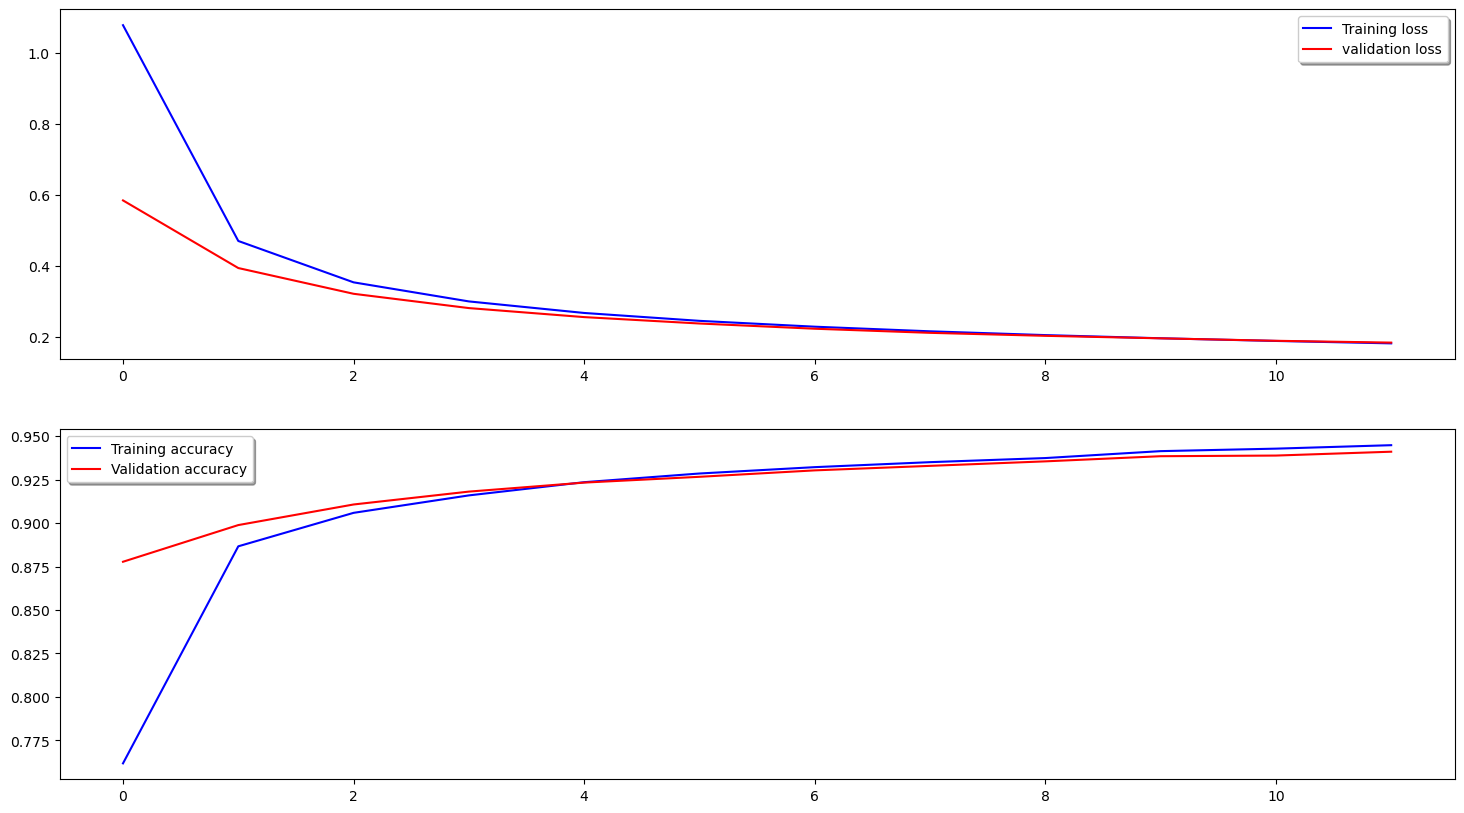

In [16]:
# Disegno l'andamento della loss e dell'accuracy sia per i dati di training che di validation
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(errors_list.history['loss'], color='b', label="Training loss")
ax[0].plot(errors_list.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(errors_list.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(errors_list.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [17]:
# valuto le performance del modello sul dataset di test
test_loss, test_acc = model.evaluate(ds_test)
print('Accuracy finale sul dataset di test: %.2f%%' % (test_acc * 100))

22/22 [==============================] - 1s 28ms/step - loss: 0.1963 - accuracy: 0.9396
Accuracy finale sul dataset di test: 93.96%


In [18]:
# paretndo dal dataset di test, ne estraggo solo le immagini, perchè il metodo di predizione non prevede
# la gestione delle altre informazioni che servono solo in fase di addestramento/valutazione
ds_test_predict = test.map(prepare_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                      .map(lambda img, lab: img, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                      .batch(BATCH_SIZE) \
                      .prefetch(tf.data.experimental.AUTOTUNE)


# eseguo la predizione con le immagini di validazione
y_pred = model.predict(ds_test_predict) 

# visualizzo i primi 10 risultati
np.set_printoptions(precision=5, suppress=True, linewidth=120)
y_pred[:10]

array([[0.99433, 0.00005, 0.00009, 0.00007, 0.00002, 0.00024, 0.00505, 0.00002, 0.0001 , 0.00003],
       [0.00231, 0.00009, 0.00003, 0.94874, 0.01357, 0.00074, 0.00325, 0.00424, 0.02671, 0.00032],
       [0.00008, 0.00005, 0.00044, 0.00159, 0.00146, 0.00003, 0.00016, 0.98186, 0.01423, 0.00011],
       [0.01013, 0.00312, 0.00107, 0.00081, 0.00021, 0.00767, 0.00012, 0.00028, 0.11279, 0.86381],
       [0.29783, 0.00058, 0.00051, 0.59687, 0.00086, 0.00309, 0.00187, 0.00018, 0.07092, 0.02729],
       [0.00023, 0.00029, 0.00004, 0.00003, 0.00001, 0.00004, 0.00001, 0.00002, 0.00008, 0.99926],
       [0.0002 , 0.00017, 0.00003, 0.00002, 0.     , 0.00003, 0.00001, 0.00002, 0.00006, 0.99945],
       [0.0024 , 0.00008, 0.00036, 0.01313, 0.00233, 0.00126, 0.94599, 0.00064, 0.0337 , 0.00011],
       [0.00026, 0.00118, 0.0008 , 0.00327, 0.00006, 0.98265, 0.01025, 0.00013, 0.00137, 0.00003],
       [0.00013, 0.00018, 0.00683, 0.98671, 0.00032, 0.00026, 0.00063, 0.00095, 0.00393, 0.00006]], dtype=flo

In [19]:
# decodifico le predizioni in identificatori di classe, sia per le predizioni che per i validation
y_pred = np.argmax(y_pred, 1) 

y_test = tf.concat([y for x, y in ds_test], axis=0)
y_test = np.argmax(y_test, 1) 

# visualizzo i primi 10 risultati della predizione trasformata
y_pred[:10]

array([0, 3, 7, 9, 3, 9, 9, 6, 5, 3])

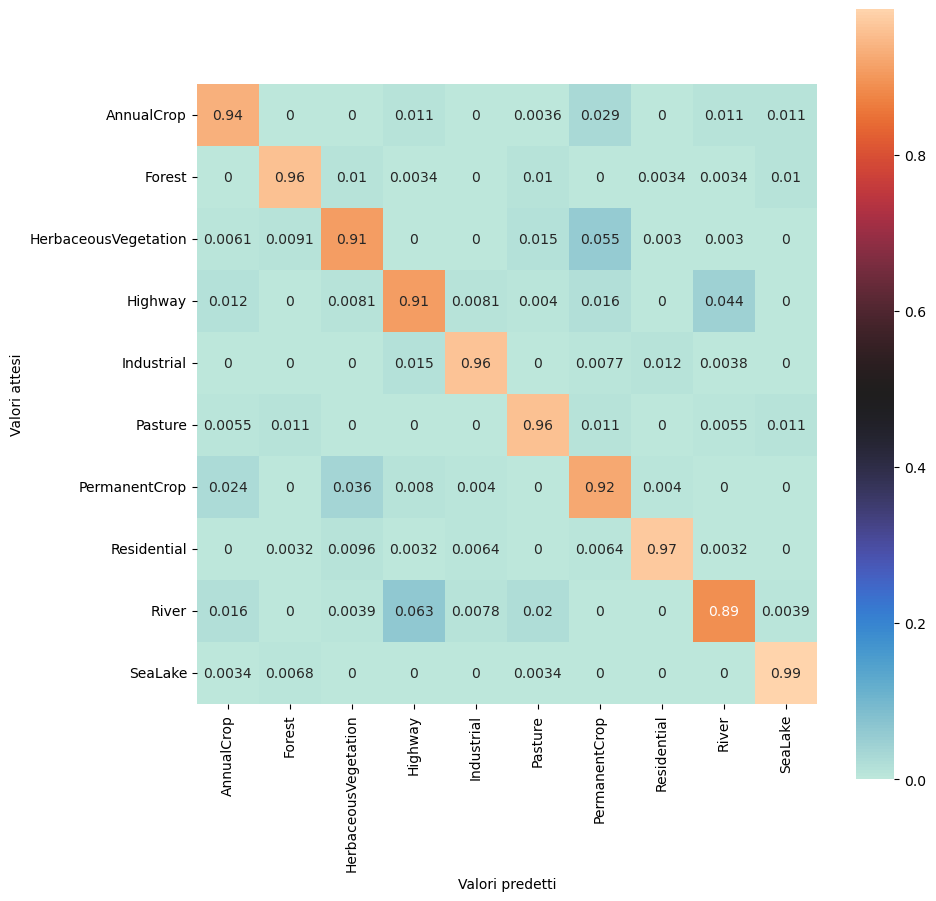

In [20]:
# ottengo le predizioni e valuto la matrice di confusione
fig = plt.figure(figsize=(10, 10)) 

# preparo la matrice di confusione
mat = confusion_matrix(y_test, y_pred, normalize='pred') 

# disegno la matrice di confusione
sns.heatmap(mat.T, square=True, annot=True, cbar=True, cmap="icefire", yticklabels=class_names, xticklabels=class_names)
plt.xlabel('Valori predetti')
plt.ylabel('Valori attesi');
plt.show();

In [21]:
# calcolo precision, recall, f1-score e support
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)

In [22]:
# visualizzo la precision per ogni classe
precision

array([0.93502, 0.95862, 0.90881, 0.90726, 0.96154, 0.95628, 0.924  , 0.96815, 0.88627, 0.98639])

In [23]:
# visualizzo la recall per ogni classe
recall

array([0.93841, 0.97203, 0.94322, 0.89286, 0.97276, 0.91623, 0.86517, 0.98065, 0.92245, 0.9699 ])

In [24]:
# visualizzo l'f1-score per ogni classe
f1

array([0.93671, 0.96528, 0.9257 , 0.9    , 0.96712, 0.93583, 0.89362, 0.97436, 0.904  , 0.97808])

In [25]:
# support rappresenta il numero di esempi di quella particolare classe contenuti negli output attesi (in questo caso y_test)
support

array([276, 286, 317, 252, 257, 191, 267, 310, 245, 299])

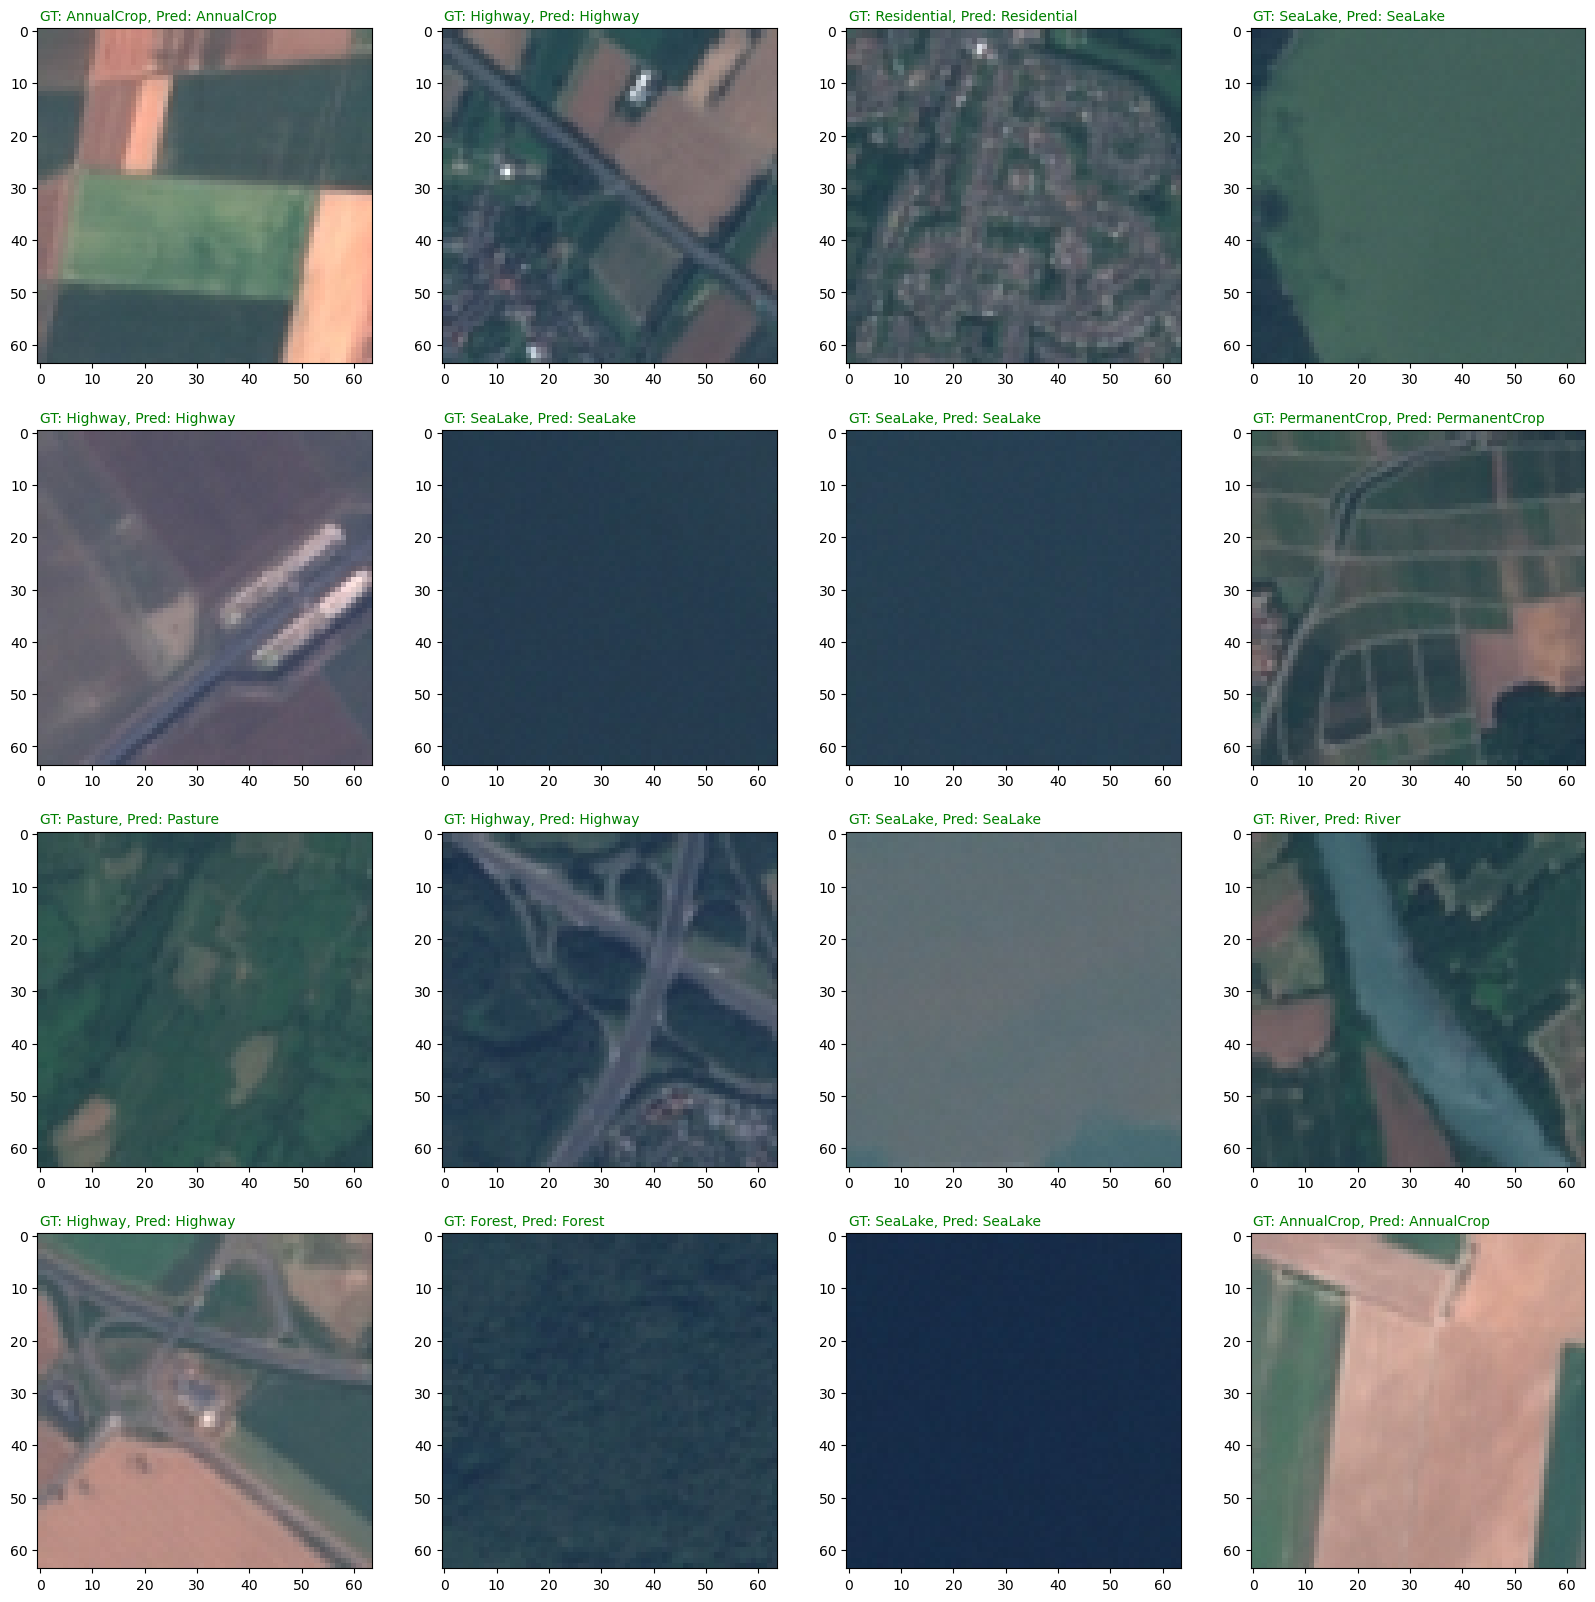

In [26]:
# prendo le immagini di test SENZA preprocessing, in modo possano essere visualizzate
ds_test_visual = test.batch(BATCH_SIZE) \
    .prefetch(tf.data.experimental.AUTOTUNE)
    
# prendo un batch dal dataset test di visualizzazione
datapoint = next(iter(ds_test_visual.take(1)))

# estraggo le immagini non preprocessate e le label 
images_batch = datapoint["image"]
labels_batch = datapoint["label"]

# ottengo le predizioni del modello preprocessando il batch di immagini ed ottenendo l'indice del one-hot
predicted_labels = tf.argmax(model.predict(prepare_image(datapoint)[0]), axis=1)

# definisco le dimensioni della mia matrice di visualizzazione
cols = 4
rows = 4

plt.figure(figsize=(20, 20))
# visualizzo cols x rows esempi
for i in range(cols * rows):
    # mi posiziono nel sottoplot i-esimo
    plt.subplot(rows, cols, (i + 1))
    # visualizzo l'immagine non preprocessata
    plt.imshow(images_batch[i], cmap=plt.get_cmap('jet'))
    # visualizzo la label di Ground Truth e quella predetta dal modello per quella particolare immagine
    plt.text(0, -2, "GT: " + str(class_names[labels_batch[i]]) + ", Pred: " + str(class_names[predicted_labels[i]]),
             fontsize = 10,
             color = 'green' if labels_batch[i] == predicted_labels[i] else 'red' )
plt.show()